<a href="https://colab.research.google.com/github/Svensone/Kaggle-Competitions/blob/master/%5Bfastai%5D_Kaggle_Bulldozer_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

1. Setup
2. Data
3. Model
4. Inference
5. Submission

In [1]:
# Setup

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# import necessary libaries

from fastai import *
from fastai.tabular import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# basic bash & create folder structure for Project

# !mkdir abc
# !echo "file" > abc/123.txt

# import os
# os.chdir('abc')

# # Now the directory 'abc' is the current working directory.
# # and will show 123.txt.
# !ls

# #change working directory
# %cd folder/folder

# # check 
# !pwd

In [3]:
# connect to kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# !pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## 2. Data

In [4]:
#list 

# list and download kaggle dataset
# ! kaggle competitions list -s bluebook
# ! kaggle competitions download -c 'name of data' -f 'train-jpg.tar.7z' -p {path where to download}

#download data
# !kaggle competitions download -c bluebook-for-bulldozers -p 'drive/My Drive/Colab Notebooks/kaggle/Bulldozer'


In [5]:
path = Path('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer')


In [6]:
path.ls()

[PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Data%20Dictionary.xlsx'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/TrainAndValid.csv.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/ValidSolution.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Test.csv.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Train.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Machine_Appendix.csv.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Valid.csv.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/TrainAndValid.7z'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/median_benchmark.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Valid.7z'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Train.7z'),
 PosixPath('/content/drive/

In [7]:
train_df = pd.read_csv(path/'Train/Train.csv', low_memory=False, parse_dates=['saledate'])

test_df = pd.read_csv(path/'Test.csv.zip', low_memory = False, parse_dates=['saledate'])

valid_df = pd.read_csv(path/'Valid.csv.zip', low_memory= False, parse_dates=['saledate'])

In [8]:
# train_df.head()
# test_df.head()
valid_df.saledate.min()

Timestamp('2012-01-01 00:00:00')

In [9]:
len(train_df), len(test_df), len(valid_df)

(401125, 12457, 11573)

## 2.2 Data Preprocessing

- sort by date
- change saleprice to log (since metric RMSLE)

## 2.3 Feature Engineering 

-add_datepart()

In [10]:
train_df = train_df.sort_values(by = 'saledate', ascending=False)

train_df = train_df.reset_index(drop=True)
train_df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,6269664,22000,1881427,7624,149,2.0,1000,NaN,NaN,2011-12-30,IT28,IT28,NaN,NaN,NaN,NaN,Wheel Loader - 100.0 to 110.0 Horsepower,New York,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,6312170,11000,1812622,9580,149,2.0,2005,NaN,NaN,2011-12-30,T190,T190,NaN,NaN,NaN,NaN,Skid Steer Loader - 1751.0 to 2201.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6265707,12500,1873075,43,149,2.0,1000,NaN,NaN,2011-12-30,416II,416,NaN,II,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,New York,BL,Backhoe Loaders,Two Wheel Drive,EROPS,None or Unspecified,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6296711,27500,1918428,24719,149,2.0,1000,NaN,NaN,2011-12-30,436B,436,B,NaN,NaN,Medium,Wheel Loader - 175.0 to 200.0 Horsepower,New York,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
4,6295141,21500,1805359,15972,149,2.0,2005,NaN,NaN,2011-12-30,8080ZTS,8080,NaN,NaN,ZTS,Small,"Hydraulic Excavator, Track - 8.0 to 11.0 Metri...",New York,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Rubber,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [11]:
# change Saleprice to log (since metric RMSLE)

train_df['SalePrice'] = np.log(train_df['SalePrice'])
train_df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,6269664,9.998798,1881427,7624,149,2.0,1000,NaN,NaN,2011-12-30,IT28,IT28,NaN,NaN,NaN,NaN,Wheel Loader - 100.0 to 110.0 Horsepower,New York,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,6312170,9.305651,1812622,9580,149,2.0,2005,NaN,NaN,2011-12-30,T190,T190,NaN,NaN,NaN,NaN,Skid Steer Loader - 1751.0 to 2201.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6265707,9.433484,1873075,43,149,2.0,1000,NaN,NaN,2011-12-30,416II,416,NaN,II,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,New York,BL,Backhoe Loaders,Two Wheel Drive,EROPS,None or Unspecified,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6296711,10.221941,1918428,24719,149,2.0,1000,NaN,NaN,2011-12-30,436B,436,B,NaN,NaN,Medium,Wheel Loader - 175.0 to 200.0 Horsepower,New York,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
4,6295141,9.975808,1805359,15972,149,2.0,2005,NaN,NaN,2011-12-30,8080ZTS,8080,NaN,NaN,ZTS,Small,"Hydraulic Excavator, Track - 8.0 to 11.0 Metri...",New York,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Rubber,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [12]:
# feature engineering (add_datepart)

add_datepart(train_df, 'saledate', drop=False)
add_datepart(test_df, 'saledate', drop=False)

train_df.tail().T

,401120,401121,401122,401123,401124
SalesID,1508502,1421628,1475641,1475662,1646770
SalePrice,9.95228,11.2385,10.0648,9.9988,9.15905
MachineID,1153157,1453580,1194367,1242833,1126363
ModelID,4138,3877,7277,7277,8434
datasource,132,132,132,132,132
...,...,...,...,...,...
saleIs_quarter_end,False,False,False,False,False
saleIs_quarter_start,False,False,False,False,False
saleIs_year_end,False,False,False,False,False
saleIs_year_start,False,False,False,False,False


In [13]:
## Processing

procs = [FillMissing, Categorify, Normalize]


In [14]:
# get cat. and cont. colums

train_df.dtypes

cols = train_df.columns.to_series().groupby(train_df.dtypes).groups
cols


{dtype('int64'): Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'YearMade', 'saleYear',
        'saleMonth', 'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
        'saleElapsed'],
       dtype='object'),
 dtype('float64'): Index(['SalePrice', 'auctioneerID', 'MachineHoursCurrentMeter'], dtype='object'),
 dtype('<M8[ns]'): Index(['saledate'], dtype='object'),
 dtype('bool'): Index(['saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end',
        'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start'],
       dtype='object'),
 dtype('O'): Index(['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
        'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
        'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
        'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
        'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
        'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',


In [15]:
cat_vars = ['SalesID', 'YearMade', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 
            'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 
            'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 
            'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls', 
            'saleYear', 'saleMonth', 'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear', 'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end', 'saleIs_quarter_start', 'saleIs_year_end', 
            'saleIs_year_start'
           ]
cont_names = ["MachineHoursCurrentMeter", "saleElapsed"]
dep_var = 'SalePrice' 

# final df

df = train_df[cat_vars + cont_names + [dep_var, 'saledate']].copy()

# create Valid Set and make sure that dates are AFTER train-set

warum nicht das eigentlich valid_df nutzen ?

In [16]:
test_df['saledate'].min(), test_df['saledate'].max()

(Timestamp('2012-05-01 00:00:00'), Timestamp('2012-11-16 00:00:00'))

In [17]:
valid_df['saledate'].max(), valid_df['saledate'].min()

(Timestamp('2012-04-28 00:00:00'), Timestamp('2012-01-01 00:00:00'))

In [18]:
train_df['saledate'].max()

Timestamp('2011-12-30 00:00:00')

In [19]:
# to learn
cut = train_df['saledate'][(train_df['saledate'] == train_df['saledate'][len(test_df)])].index.max()
cut

12621

In [20]:
len(test_df)

12457

In [21]:
valid_idx = range(cut)
valid_idx

range(0, 12621)

In [22]:
# DataBunch

data = (TabularList
        .from_df(df, path= path, cont_names=cont_names, cat_names=cat_vars, procs=procs)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls = FloatList).
        databunch())

# notes:
# label_from_df with label_cls=Floatlist so autom. regression
# no test_set added (probably since only now, after competition ended test_set availabel)
# maybe same for valid ?

In [23]:
data.show_batch(3)

SalesID,YearMade,MachineID,ModelID,datasource,auctioneerID,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,MachineHoursCurrentMeter_na,MachineHoursCurrentMeter,saleElapsed,target
2753720,1995,1791592,10493,149,1.0,High,L180,L180,#na#,#na#,#na#,Medium,Wheel Loader - 250.0 to 275.0 Horsepower,Colorado,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,Yes,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,2011,6,23,7,1,158,False,False,False,False,False,False,False,1.3570,1.2421,10.085809
1762231,1988,1428877,9109,132,24.0,Medium,WA250,WA250,#na#,#na#,#na#,#na#,Wheel Loader - 120.0 to 135.0 Horsepower,Georgia,WL,Wheel Loader,#na#,OROPS,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,1991,6,25,20,3,171,False,False,False,False,False,False,False,0.0238,-2.2612,10.373491
1429812,2001,595659,2752,132,3.0,#na#,D4CIII,D4,C,III,#na#,#na#,"Track Type Tractor, Dozer - 75.0 to 85.0 Horsepower",Unspecified,TTT,Track Type Tractors,#na#,OROPS,#na#,#na#,#na#,#na#,Hydrostatic,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,#na#,#na#,2003,5,22,29,3,149,False,False,False,False,False,False,True,-0.0709,-0.1660,10.518673


## 3. Model

1. Build

y_range, layers, (tensor), dropout, emb_drop, metrics

2. Train
3. Fine-tune


In [24]:
y_range_max = df.SalePrice.max() * 1.2
y_range = torch.tensor([0, y_range_max], device=defaults.device)
y_range

tensor([ 0.0000, 14.2363], device='cuda:0')

In [25]:

learn = tabular_learner(data, layers=[1000, 500], ps=[1e-3, 1e-2],
                        emb_drop=0.04, y_range= y_range, metrics = rmse)
# learn.model

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


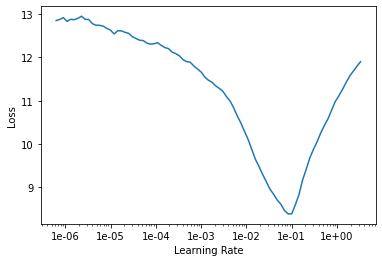

In [ ]:
# Train

learn.lr_find()
learn.recorder.plot(sugesstion=True)

In [ ]:
lr_rate = 1e-2
learn.fit_one_cycle(2, lr_rate, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.087930,0.095691,0.305929,32:23
1,0.048023,0.056612,0.234294,32:47


In [ ]:
learn.save('1')

In [ ]:
learn.load('1')

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 6.92E-03


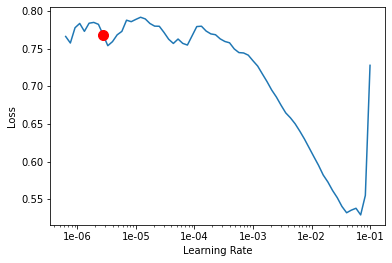

In [27]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [28]:
lr_rate = 1e-2
learn.fit_one_cycle(4, slice(lr_rate), wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.099865,0.085984,0.289671,10:00
1,0.093639,0.088644,0.294492,10:05
2,0.069404,0.062901,0.247159,10:12
3,0.037232,0.054024,0.228994,10:12


In [ ]:
learn.fit_one_cycle(4, slice(lr_rate), wd=0.2)

In [ ]:
# best RMSE (since log of SalePrice before RMSLE)
0.

## 4. Submission

get sample_sub

to_csv

!kaggle competitions submit

In [ ]:
sample_sub = pd.read_csv()

## Submission

In [ ]:

#upload
!kaggle competitions submit titanic -f '/content/drive/My Drive/Colab Notebooks/kaggle/titanic/submission.csv' -m ''